In [21]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# generates preprocessed datasets for our models

batchSize = 1000
noiseDim = 20

noise1, noise2, loader1, loader2, loader_mix_val, vallabel, loader_mix_test, testlabel = preprocessing.gen_loaders(
    noiseDim, 
    batchSize
)

Spike generator training


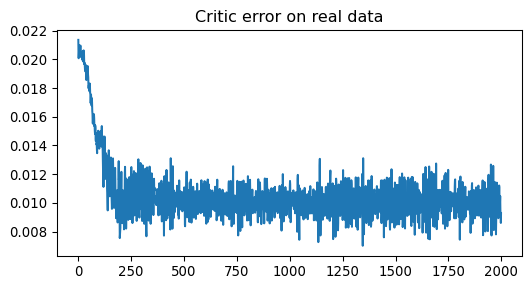

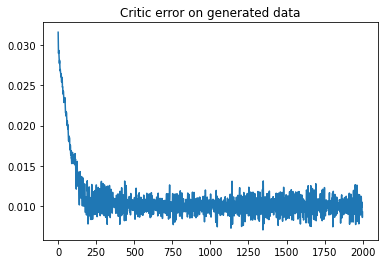

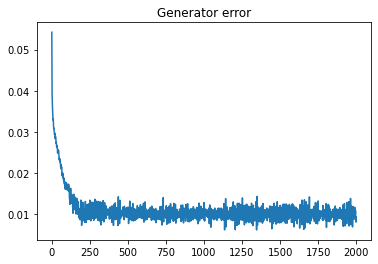


Epoch 199

Generated example:


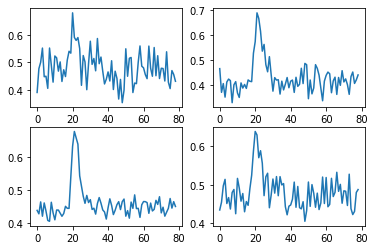

err_d 0.009267590008676052
err_d_g 0.009288141503930092
err_G 0.0093685919418931


In [45]:
# declares and trains the gan for spikes 

gen1 = gans.Generator(inputSize=noiseDim, hiddenSize=5, outputSize=79)
disc1 = gans.Critic(inputSize=79, hiddenSize=5)

print("Spike generator training")

gans.adversarial_trainer( 
    train_loader = loader1, 
    noise_loader = noise1,
    generator = gen1, 
    discriminator = disc1, 
    epochs = 200,
    learningRate = 0.001,
    Diters = 5,
    Giters = 1,
    printEpochs = 200,
)

Background generator training


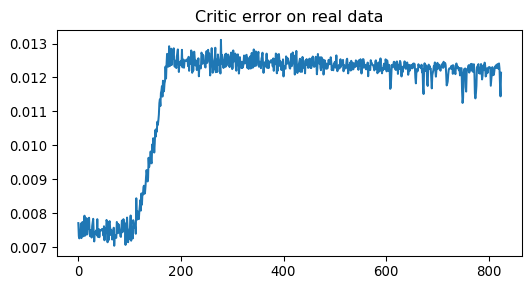

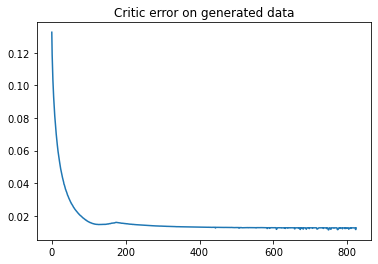

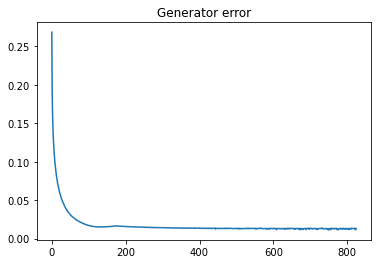


Epoch 4

Generated example:


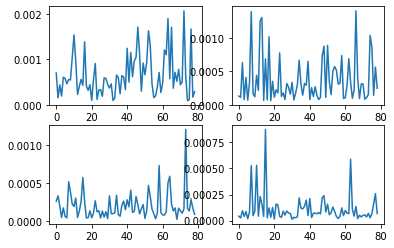

err_d 0.012139146216213703
err_d_g 0.012489628978073597
err_G 0.013231918215751648


In [25]:
# declares and trains the gan for hash

gen2 = gans.Generator(inputSize=noiseDim, hiddenSize=25, outputSize=79)
disc2 = gans.Critic(inputSize=79, hiddenSize=25)
print("Background generator training")

gans.adversarial_trainer( 
    train_loader = loader2, 
    noise_loader = noise2,
    generator = gen2, 
    discriminator = disc2, 
    epochs = 5,
    learningRate = 0.001,
    Diters = 5,
    Giters = 1,
    printEpochs = 5,
)

In [ ]:
# separates the samples from loader_mix_val

cleanextractedSpikesValidation = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=loader_mix_val,
    epochs=500
)

In [ ]:
# some interpretation of results

import numpy as np
import torch
import matplotlib.pyplot as plt

out = []

extractedSpikesValidation = np.array(cleanextractedSpikesValidation)
extractedSpikesValidation = torch.from_numpy(extractedSpikesValidation).float()


for [window] in extractedSpikesValidation:
    out.append(disc1.forward(window.to(device)).data.cpu().numpy())

out = np.array(out).flatten()

treshold = 0.02

res = []

for i in out:
    if i >= treshold:
        res.append(1)
    else:
        res.append(0)
        
plt.plot(out)
plt.show()
plt.plot(res)
plt.show()
plt.plot(vallabel)
plt.show()

truepos = 0
falsepos = 0
trueneg = 0
falseneg = 0

for i in range(0, len(vallabel)):
    if vallabel[i] == 1:
        if res[i] == 1:
            truepos += 1
        else:
            falseneg += 1
    else:
        if res[i] == 1:
            falsepos += 1
        else:
            trueneg += 1

precision = truepos / (truepos + falsepos)
recall = truepos / (truepos + falseneg)        
    
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("Accuracy: {}".format((truepos + trueneg) / len(vallabel)))
print("F1: {}".format(2 * ((precision * recall)/(precision+recall))))